<a href="https://colab.research.google.com/github/opherdonchin/Regression-by-group/blob/main/Regression_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I built this using the outline in this page: [Bayesian Linear Regression Using PyMC3](https://ostwalprasad.github.io/machine-learning/Bayesian-Linear-Regression-using-PyMC3.html)

In [18]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    !pip install pymc3
    !pip install seaborn
    !pip install arviz

In [19]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import arviz as az
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder
import pickle
import theano.tensor as tt


In [20]:
# url_impl_trials = 'https://raw.githubusercontent.com/opherdonchin/Regression-by-group/main/dataExplicit.csv'
# url_expl_trials = 'https://raw.githubusercontent.com/opherdonchin/Regression-by-group/main/dataExplicit.csv'
# url_impl = 'https://raw.githubusercontent.com/opherdonchin/Regression-by-group/main/implAndAfter_NoLandmarks.csv'
# url_expl = 'https://raw.githubusercontent.com/opherdonchin/Regression-by-group/main/implAndAfter_NoLandmarks.csv'
# url_landmarks = 'https://raw.githubusercontent.com/opherdonchin/Regression-by-group/main/data/dataLandmarks.csv'
# url_no_landmarks = 'https://raw.githubusercontent.com/opherdonchin/Regression-by-group/main/data/dataNoLandmarks.csv'
url_landmarks = 'data\dataLandmarks.csv'
url_no_landmarks = 'data\dataNoLandmarks.csv'

landmark_data = pd.read_csv(url_landmarks, sep=",", on_bad_lines='skip')
no_landmark_data = pd.read_csv(url_no_landmarks, sep=",", on_bad_lines='skip')

In [21]:
landmark_data.head()

,eyeHandDiff,eyes,afterEffect,subjectN,groups
0,10.082297,-31.546520,-8.875644,1,1
1,-10.012122,-27.271097,-3.625990,1,1
2,-33.441301,14.607681,-15.002860,1,1
3,-95.241374,57.084439,-11.144006,1,1
4,-121.630474,99.886312,-17.726672,1,1


In [22]:
print('Running on the PyMC3 v{}'.format(pm.__version__))


Running on the PyMC3 v3.11.4


In [23]:
def regression_model(y,x,s,y0,x0,use_beta0):
  s_idx, s_vals = pd.factorize(s, sort=True)
  coords = {"subject": s_vals}
  with pm.Model(coords=coords) as model:
    #Priors
    beta = pm.Normal('beta', mu=0, sd=10, testval=0.0)
    if use_beta0:
      beta0 = pm.Normal('beta0', mu=0, sd=30, testval=0.0)
    chol, corr, stds = pm.LKJCholeskyCov("chol", n=2, eta=2.0, sd_dist=pm.Exponential.dist(5.0), compute_corr=True)
    # Deterministics
    xs = pm.Normal('xs', mu=0, sd=30, testval=0.0, dims="subject")
    if use_beta0:
      mu = beta*(xs-x0) + beta0+y0 
    else:
      mu = beta*(xs-x0) + y0
    ys = pm.Normal('ys', mu=mu, sd=30, testval=0.0, dims="subject")
    mu_o = tt.stack([xs,ys]).T
    # Likelihood 
    obs = pm.MvNormal('obs', mu=mu_o[s_idx,:], chol=chol, observed=np.array([o for o in zip(x,y)]))
  return model


In [66]:
landmark_data["landmarks"] = True
no_landmark_data["landmarks"] = False
data = pd.concat([landmark_data, no_landmark_data], ignore_index=True)

independent_variables = ['eyeHandDiff', 'eyes']
x0_by_variable = [0, -30]
y0_by_variable = [0, 0]

b0_strings = ["intercept", "homogeneous"]

model_list = {b0_string: [] for b0_string in b0_strings}
for independent_variable,x0,y0 in zip(independent_variables,x0_by_variable,y0_by_variable):
    
    for landmarks in [True, False]:
        landmark_string = "landmarks" if landmarks else "no landmarks"
        this_landmark_data = data.loc[data["landmarks"]==landmarks,:]
        these_groups = this_landmark_data["groups"].unique()
        for group in these_groups:
            this_group_data = this_landmark_data.loc[data["groups"]==group,:]
            x = this_group_data[independent_variable]
            y = this_group_data['afterEffect']
            s = this_group_data['subjectN']
            
            for b0_string in b0_strings:
                model_name = f'{landmark_string} group {group} {b0_string} using {independent_variable}'
                model_list[b0_string].append({
                    'name': model_name,
                    'group': group,
                    'landmarks': landmark_string,
                    'variable': independent_variable,
                    'x': x,
                    'y': y,
                    's': s,
                    'x0': x0,
                    'y0': y0,
                    'use_b0': b0_string == b0_strings[0]
                })

model_list_out = open("model_list.pickle","wb")
pickle.dump(model_list, model_list_out)

In [ ]:
all_model = {b0_string: [] for b0_string in b0_strings}
all_trace = {b0_string: [] for b0_string in b0_strings}
all_az = {b0_string: [] for b0_string in b0_strings}
num_models = len(model_list[b0_strings[0]])

do_models = np.arange(0,num_models)
for b0_string in b0_strings:
  for i,m in enumerate(model_list[b0_string]):
    print('************************')
    print(f'Starting {m["name"]} ({i}/{num_models} for {b0_string} model)')
    model = regression_model(m["y"],m["x"],m["s"],m["y0"],m["x0"],m["use_b0"])
    with model:
      trace = pm.sample(draws=3300, cores=3)
    az_trace = az.from_pymc3(model=model, trace=trace)

    all_model[b0_string].append(model) 
    all_trace[b0_string].append(trace)
    all_az[b0_string].append(az_trace)
    az.to_netcdf(az_trace, f'samples\\{m["name"]}')

    print(f'Done with {m["name"]} ({i}/{num_models} for {b0_string} model)')
  

In [ ]:
for i in range(num_models):
  for b0_string in b0_strings:
    trace = all_az[b0_string][i]
    m = model_list[b0_string][i]
    ax = az.plot_trace(trace)
    ax[0][0].get_figure().suptitle(f'{m["name"]}')

<AxesSubplot:>

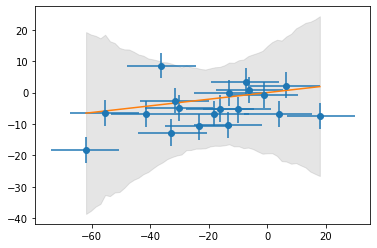

In [86]:
def plot_regression(data: az.InferenceData, ax: plt.Axes = None):
    post = data.posterior

    post_mean = post[["xs","ys"]].mean(dim=['chain', 'draw'])
    post_hdi = az.hdi(post[["xs","ys"]])

    x_mean = post_mean["xs"]
    y_mean = post_mean["ys"]
    x_upper = post_hdi["xs"].sel({"hdi":"higher"}) - x_mean
    x_lower = x_mean - post_hdi["xs"].sel({"hdi":"lower"})
    y_upper = post_hdi["ys"].sel({"hdi":"higher"}) - y_mean
    y_lower = y_mean - post_hdi["ys"].sel({"hdi":"lower"})
        
    if ax is None:
        ax = plt.gca()

    ax.errorbar(x_mean, y_mean, xerr=[x_lower, x_upper], yerr=[y_lower, y_upper], fmt='o')

    x_hat = np.linspace(np.min(x_mean), np.max(x_mean), 50)
    beta = post["beta"].mean().to_numpy()
    y_hat = x_hat*beta

    ax.plot(x_hat, y_hat)

    beta_trace = post["beta"]
    if "beta0" in post.keys():
        beta0_trace = post["beta0"]
    else:
        beta0_trace = 0

    y_lower = list()
    y_higher = list()
    for x_mod in x_hat:
        y_mod_trace = beta_trace*x_mod + beta0_trace
        y_mod_hdi = az.hdi(y_mod_trace).to_array().to_numpy()
        y_lower.append(y_mod_hdi[0][0])
        y_higher.append(y_mod_hdi[0][1])
    ax.fill_between(x_hat, y_lower, y_higher, color='grey', alpha=0.2)
    return ax

plot_regression(all_az['intercept'][0])

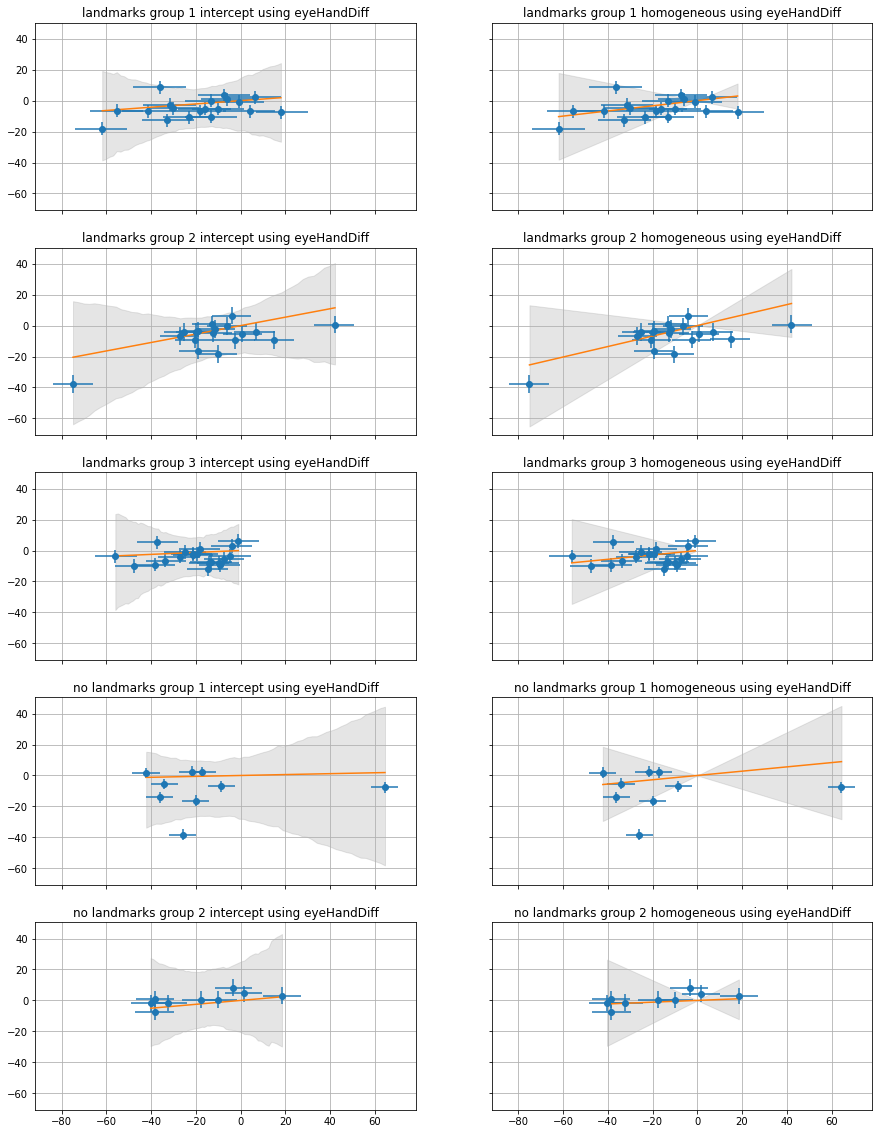

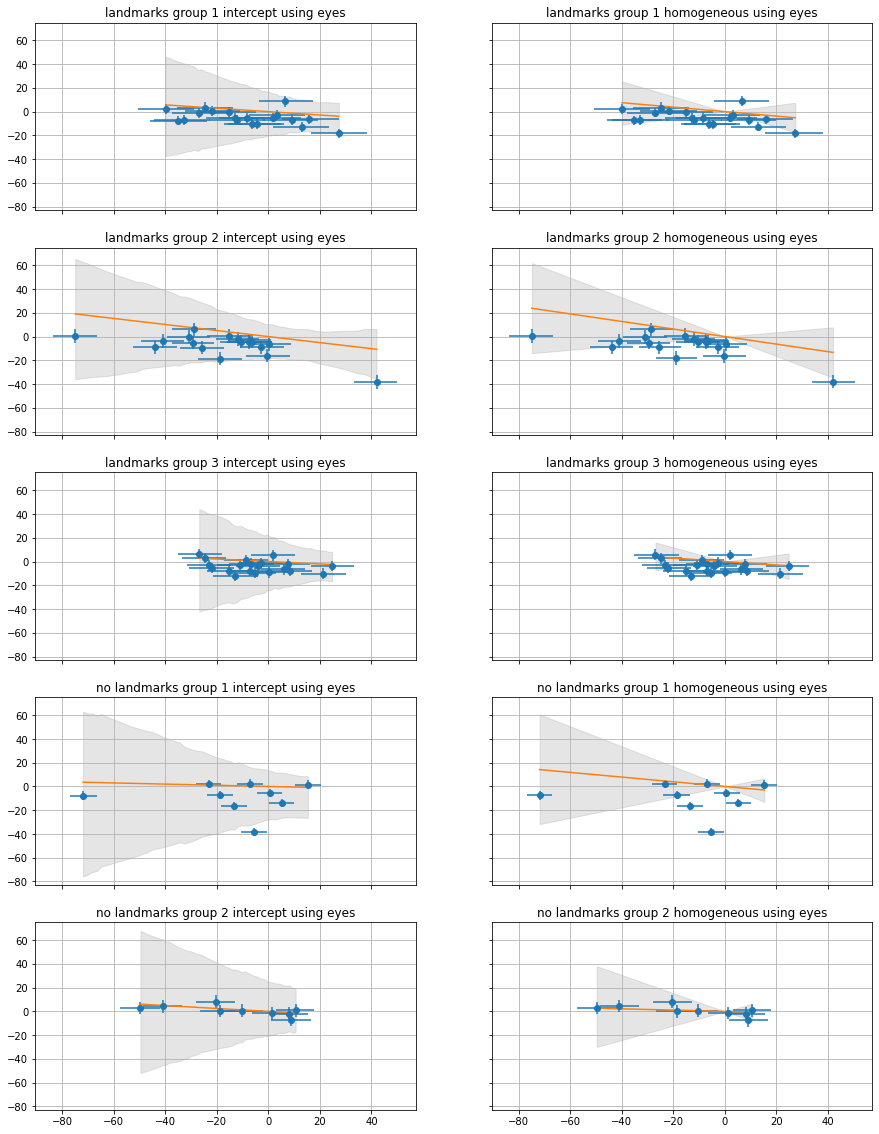

In [89]:
num_models_per_variable = int(num_models/2)
num_variables = 2

for var_num in range(num_variables):
  fig, ax = plt.subplots(nrows=num_models_per_variable, ncols=2, figsize=(15, 20), sharex=True, sharey=True)
  for i in range(num_models_per_variable):
    mi = var_num*num_models_per_variable+i
    for j,b0_string in enumerate(b0_strings):
      trace = all_az[b0_string][mi]
      m = model_list[b0_string][mi]
      plot_regression(data=trace, ax=ax[i,j])
      ax[i,j].grid()
      ax[i,j].set_title(m["name"])


In [96]:
for i in range(int(num_models/2)):
  i_diff = i
  i_eyes = i+5
  yesb0 = b0_strings[0]
  nob0 = b0_strings[1]
  name_di = model_list[yesb0][i_diff]["name"]
  name_dh = model_list[nob0][i_diff]["name"]
  name_ei = model_list[yesb0][i_eyes]["name"]
  name_eh = model_list[nob0][i_eyes]["name"]
  print(f'Comparing {name_di} and {name_dh}')
  print(f'{name_ei} and {name_eh}')
  print(az.compare({name_di: all_az[yesb0][i_diff], name_dh: all_az[nob0][i_diff], 
  name_ei: all_az[yesb0][i_eyes], name_eh: all_az[nob0][i_eyes]}, ic="waic"))
  

Comparing landmarks group 1 intercept using eyeHandDiff and landmarks group 1 homogeneous using eyeHandDiff
landmarks group 1 intercept using eyes and landmarks group 1 homogeneous using eyes


c:\miniconda3\envs\Regression\lib\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
c:\miniconda3\envs\Regression\lib\site-packages\arviz\stats\stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
c:\miniconda3\envs\Regression\lib\site-packages\arviz\stats\stats.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale)])
c:\miniconda3\envs\Regression\lib\site-packages\arviz\stats\stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC start

                                                 rank         waic     p_waic  \
landmarks group 1 intercept using eyes              0 -3319.038166  69.110435   
landmarks group 1 homogeneous using eyes            1 -3319.246133  69.789870   
landmarks group 1 homogeneous using eyeHandDiff     2 -3357.491001  70.346922   
landmarks group 1 intercept using eyeHandDiff       3 -3359.074795  70.878366   

                                                    d_waic    weight  \
landmarks group 1 intercept using eyes            0.000000  0.798733   
landmarks group 1 homogeneous using eyes          0.207967  0.000000   
landmarks group 1 homogeneous using eyeHandDiff  38.452834  0.201267   
landmarks group 1 intercept using eyeHandDiff    40.036629  0.000000   

                                                        se        dse  \
landmarks group 1 intercept using eyes           88.147416   0.000000   
landmarks group 1 homogeneous using eyes         88.362615   0.259746   
landmarks grou

c:\miniconda3\envs\Regression\lib\site-packages\arviz\stats\stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
c:\miniconda3\envs\Regression\lib\site-packages\arviz\stats\stats.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale)])
c:\miniconda3\envs\Regression\lib\site-packages\arviz\stats\stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
c:\miniconda3\envs\Regression\lib\site-packages\arviz\stats\stats.py:212: FutureWarning: The frame.append method is deprecated and 

                                                 rank         waic     p_waic  \
landmarks group 2 homogeneous using eyes            0 -3174.106787  76.415431   
landmarks group 2 intercept using eyes              1 -3175.678223  77.148135   
landmarks group 2 homogeneous using eyeHandDiff     2 -3192.448885  75.550566   
landmarks group 2 intercept using eyeHandDiff       3 -3194.043386  76.417417   

                                                    d_waic        weight  \
landmarks group 2 homogeneous using eyes          0.000000  8.291993e-01   
landmarks group 2 intercept using eyes            1.571437  4.151570e-16   
landmarks group 2 homogeneous using eyeHandDiff  18.342098  1.708007e-01   
landmarks group 2 intercept using eyeHandDiff    19.936599  0.000000e+00   

                                                         se       dse  \
landmarks group 2 homogeneous using eyes         101.564824  0.000000   
landmarks group 2 intercept using eyes           102.665115  1.5510

c:\miniconda3\envs\Regression\lib\site-packages\arviz\stats\stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
c:\miniconda3\envs\Regression\lib\site-packages\arviz\stats\stats.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale)])
c:\miniconda3\envs\Regression\lib\site-packages\arviz\stats\stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
c:\miniconda3\envs\Regression\lib\site-packages\arviz\stats\stats.py:212: FutureWarning: The frame.append method is deprecated and 

                                                 rank         waic     p_waic  \
landmarks group 3 intercept using eyes              0 -3407.030392  79.169192   
landmarks group 3 homogeneous using eyes            1 -3407.693886  80.799885   
landmarks group 3 homogeneous using eyeHandDiff     2 -3441.111331  78.017083   
landmarks group 3 intercept using eyeHandDiff       3 -3443.356572  78.739918   

                                                    d_waic    weight  \
landmarks group 3 intercept using eyes            0.000000  0.177077   
landmarks group 3 homogeneous using eyes          0.663494  0.577054   
landmarks group 3 homogeneous using eyeHandDiff  34.080940  0.245869   
landmarks group 3 intercept using eyeHandDiff    36.326180  0.000000   

                                                         se        dse  \
landmarks group 3 intercept using eyes           105.955256   0.000000   
landmarks group 3 homogeneous using eyes         106.100038   1.031121   
landmarks g

c:\miniconda3\envs\Regression\lib\site-packages\arviz\stats\stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
c:\miniconda3\envs\Regression\lib\site-packages\arviz\stats\stats.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale)])
c:\miniconda3\envs\Regression\lib\site-packages\arviz\stats\stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
c:\miniconda3\envs\Regression\lib\site-packages\arviz\stats\stats.py:212: FutureWarning: The frame.append method is deprecated and 

                                                    rank         waic  \
no landmarks group 1 homogeneous using eyes            0 -1401.967272   
no landmarks group 1 intercept using eyes              1 -1402.012870   
no landmarks group 1 homogeneous using eyeHandDiff     2 -1443.560084   
no landmarks group 1 intercept using eyeHandDiff       3 -1443.588875   

                                                       p_waic     d_waic  \
no landmarks group 1 homogeneous using eyes         28.584889   0.000000   
no landmarks group 1 intercept using eyes           28.712039   0.045598   
no landmarks group 1 homogeneous using eyeHandDiff  28.318200  41.592812   
no landmarks group 1 intercept using eyeHandDiff    28.387643  41.621603   

                                                          weight         se  \
no landmarks group 1 homogeneous using eyes         9.290778e-01  28.681093   
no landmarks group 1 intercept using eyes           0.000000e+00  28.706563   
no landmarks gro

c:\miniconda3\envs\Regression\lib\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
c:\miniconda3\envs\Regression\lib\site-packages\arviz\stats\stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
c:\miniconda3\envs\Regression\lib\site-packages\arviz\stats\stats.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale)])
c:\miniconda3\envs\Regression\lib\site-packages\arviz\stats\stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC start

                                                    rank        waic  \
no landmarks group 2 homogeneous using eyes            0 -1623.50424   
no landmarks group 2 intercept using eyes              1 -1624.75421   
no landmarks group 2 intercept using eyeHandDiff       2         NaN   
no landmarks group 2 homogeneous using eyeHandDiff     3         NaN   

                                                       p_waic    d_waic  \
no landmarks group 2 homogeneous using eyes         79.608472  0.000000   
no landmarks group 2 intercept using eyes           81.238989  1.249969   
no landmarks group 2 intercept using eyeHandDiff          NaN       NaN   
no landmarks group 2 homogeneous using eyeHandDiff        NaN       NaN   

                                                    weight          se  \
no landmarks group 2 homogeneous using eyes           0.25  122.349756   
no landmarks group 2 intercept using eyes             0.25  123.053678   
no landmarks group 2 intercept using eyeH

c:\miniconda3\envs\Regression\lib\site-packages\arviz\stats\stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
c:\miniconda3\envs\Regression\lib\site-packages\arviz\stats\stats.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale)])


In [ ]:
xx = i_row.iloc[0,:]
print(xx["name"])


landmarks group 1 homogeneous using eyeHandDiff


In [ ]:
model_frame = pd.DataFrame(model_list)

homogenous_rows = model_frame[model_frame["use_b0"] == True]
intercept_indexes = model_frame[model_frame["use_b0"] == False]

h_row = homogenous_rows.isel[0]
group = h_row["group"]
landmarks = h_row["landmarks"]
variable = h_row["variable"]
h = h_row.index

i_row = model_frame[np.invert(model_frame["use_b0"]) & (model_frame["group"] == group) & (model_frame["landmarks"] == landmarks) & (model_frame["variable"] == variable)]
i = i_row.index


KeyError: 0